# Wine Pricing Study

#### Author: Steve Diamond [(GitHub)](https://github.com/StevenWDiamond)

### Table of Contents

#### In This Notebook:
- [Modeling](#Modeling)
    - [Model Preparation](#Model-Preparation)
    - [Models](#Models)
        - [Baseline Model](#Baseline-Model)  
        - [Linear Regression - Original Data](#Linear-Regression-(with-original-data))
        - [Linear Regression - KModes Data](#Linear-Regression-(with-KModes-data-added))
        - [Ridge Regression](#Ridge-Regression)
        - [LASSO Regression](#LASSO-Regression)
        - [Decision Tree Regression](#Decision-Tree-Regression)
        - [Random Forest Regresssion](#Random-Forest-Regresssion)
        - [Extra Trees Regression](#Extra-Trees-Regression)
        - [Feed Forward Neural Network](#Feed-Forward-Neural-Network)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Residual Analysis](#Residual-Analysis)
    - [Coefficient Analysis/Interpretation](#Coefficient-Analysis/Interpretation)
- [Conclusions/Next Steps](#Conclusions/Next-Steps)
- [References](#References)

#### [Data Cleaning/EDA Notebook](DataCleanEDA.ipynb)
#### (includes links to the following)
- Loading Data
    - Library Imports 
    - Data Imports
    - Data Dictionary
- Data Cleaning
    - Overview Analysis
    - Cleaning/EDA Needs by Column
    - Removing Non-Red Wines
    - Removing Columns
    - Imputing Data
    - Removing Additional Wines
    - Drop Non-Prices Rows
    - Variety Combinations
    - Winery Data
- Exploratory Data Analysis
    - Feature Engineering
        - Province & Region Data
        - Special Designation Column
        - Vintage Column from Title Column
    - Data Correlations
    - Data Distributions
    - Data Interations
        - Price vs Review Score
        - Cost-Per-Point Analysis
    - Review Word Frequency Analysis
    - Post-EDA Data Preparation
- Return To EDA

#### [KPrototypes Notebook](kprototyes.ipynb)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import six
import seaborn as sns

import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import np_utils
from tensorflow.keras import backend

RANDOM_STATE = 42

random_state = RANDOM_STATE

In [2]:
# allow for full printing as needed
pd.set_option("display.max_rows", None, "display.max_columns", None)

[Table of Contents](#Table-of-Contents)
## Modeling

### Model Preparation
Prior to modeling, there are several setup steps we needed to take:
- Imported two DataFrames:
    - Cleaned data from Data Cleaning/EDA notebook.
    - Cleaned data combines with KPrototypes cluster data. 

In [3]:
df = pd.read_csv('../data/clean_eda_data.csv')

In [4]:
df_w_kmodes = pd.read_csv('../data/dummied_plus_kproto.csv')

- Created a function to calculate RMSE for our model scoring.

In [5]:
# defining function to calculate RMSE for Train and Test scores 
def rmse(y_set, y_hat_set):
    y_set_exp     = np.exp(y_set)
    y_hat_set_exp = np.exp(y_hat_set)
    return metrics.mean_squared_error(y_set_exp,y_hat_set_exp) ** .5

- Created several versions of X and y data for use in various models.
    1. X and y for non-KPrototypes data.
    2. X_k for the KPrototypes data (y data is the same).
    3. A non-logged version of the target data for the neural network to use.
        * Note that this is paired with the KPrototypes X data as we had already determined to use this dataframe when we imported the data into this notebook.
    4. Train-test split data for all of the above.

In [6]:
# X and y for non-KPrototypes data 
X = df.drop(columns='price')
y = np.log(df['price'])

# X_k and y_k for the KPrototypes data 
X_k = df_w_kmodes.drop(columns='price')

# A non-logged version of the target data for the neural network to use
y_nn = df_w_kmodes['price']

# Train-test split data for all of these
X_k_train, X_k_test, y_train, y_test = train_test_split(X_k, y, random_state = RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_k, y_nn, random_state = RANDOM_STATE)


[Table of Contents](#Table-of-Contents)
## Models

### Baseline Model
The first step in model comparison is to build a baseline model using a dummy regressor, which uses mean values to make predictions without paying any attention to the input data. We will use it as a baseline to for the other models we build.

In [7]:
# Instantiating and fitting the model in a pipeline
pipe_dummy = Pipeline([
    ('dummy', DummyRegressor())
])
pipe_dummy.fit(X_train,y_train)

Pipeline(steps=[('dummy', DummyRegressor())])

In [8]:
# Creating grid search parameters - in this case, just to be consistent
pipe_dummy_params = {
    'dummy__strategy': ['mean']
}

In [9]:
# Instantiating the GridSearch
pipe_dummy_gs = GridSearchCV(pipe_dummy,
                             pipe_dummy_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [10]:
# Fitting the GridSearch
pipe_dummy_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('dummy', DummyRegressor())]),
             param_grid={'dummy__strategy': ['mean']},
             scoring='neg_root_mean_squared_error')

**Best Parameters**

We performed hyperparameter tuning on each pipeline. 
* The settings in this notebook represent the combinations that scored the best.

In [11]:
# finding the parameters that grid search found to be the best 
pipe_dummy_gs.best_params_

{'dummy__strategy': 'mean'}

In [12]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

**Interpretation**

These parameter(s) performed best for this model.

|**Parameter**|**Best Choice**|
|:---|:---|
|dummy__strategy|mean|

In [13]:
# finding and saving the cross-validation score
dummy_cv = cross_val_score(pipe_dummy_gs, X, y, cv=5).mean()
dummy_cv

-0.664413974769046

**IMPORTANT NOTES**

There are three things that need to be said in relation to all of our grid searches and best scores:

1. The cross-value score is negative so that they get larger (less negative) as they get better.
    * That said, we will refer to them as getting smaller to be in sync with our RMSE scores (which are positive).
2. The RMSE cross-value scores use the logged-pricing data and, while we can compare them to each other, we cannot compare them to our other RMSE data which were scored with exponentiated data.
    * It is not possible to get a matching cross-value score from this software.

In [14]:
# Calling the function created above to determine our Train Score RMSE for this model 
dummy_train = rmse(y_train,pipe_dummy_gs.predict(X_k_train))
dummy_train

43.80603110770548

In [15]:
# Calling the function created above to determine our Test Score RMSE for this model 
dummy_test = rmse(y_test,pipe_dummy_gs.predict(X_k_test))
dummy_test

48.29262238872249

**Interpretation**
- The train and test scores for our Dummy Model were 43.81 and 48.29.
- RMSE is an absolute measure of fit and can be interpreted as the standard deviation of the unexplained variance. It also has the useful property of being in the same units as the target variable (Price in this case). 
    * Lower values of RMSE indicate better fit. 
- Though it is hard to judge an RMSE at first glance, our model has what looks to be a pretty good baseline model.
    * Note that our mean price was just over \$40 so this seems to be more in the ballpark than some baseline models.


[Table of Contents](#Table-of-Contents)
### Linear Regression (with original data)

Next, we wanted to run our data through a linear regression model. We did so with the following three goals in mind.

1. Compare the results of linear regression to our baseline results.
2. Determine which of our datasets to use for the remainder of our study, the set if data without the KPrototypes column or the data that includes the KPrototypes column.
3. Use linear regression for coefficient interpretation (with this in mind, we used statsmodels instead of scikit learn for this modeling).

In [16]:
# Telling statsmodels to add a constant (Intercept)
X_train = sm.add_constant(X_train)

In [17]:
# Creating and fitting the OLS (linear regression) model
model = sm.OLS(y_train,X_train)
results = model.fit()

In [18]:
# Calling the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     202.6
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:47:12   Log-Likelihood:                -30816.
No. Observations:               53799   AIC:                         6.237e+04
Df Residuals:                   53430   BIC:                         6.565e+04
Df Model:                         368                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -5.3932      0.093    -58.181      0.000      -5.575      -5.212
points                                             0.0960      0.001    139.751      0.000       0.095       0.097
high_q_term                                        0.0673      0.005     12.772      0.000       0.057       0.078
vintage                                            0.0080      0.001     13.821      0.000       0.007       0.009
country_Argentina                                  0.0939      0.064      1.477      0.140      -0.031       0.218
country_Australia                                  0.1551      0.062      2.513      0.012       0.034       0.276
country_Austria                                    0.2163      0.077      2.796      0.005       0.065       0.368
country_Brazil                                     0.3314      0.132      2.508      0.012       0.072       0.590
country_Bulgaria                                  -0.3716      0.128     -2.899      0.004      -0.623      -0.120
country_Canada                                     0.5066      0.109      4.636      0.000       0.292       0.721
country_Chile                                      0.0604      0.062      0.970      0.332      -0.062       0.182
country_Croatia                                    0.1285      0.148      0.870      0.384      -0.161       0.418
country_France                                     0.2449      0.057      4.317      0.000       0.134       0.356
country_Georgia                                   -0.5099      0.227     -2.248      0.025      -0.955      -0.065
country_Germany                                    0.1143      0.076      1.506      0.132      -0.034       0.263
country_Greece                                     0.1336      0.075      1.787      0.074      -0.013       0.280
country_Hungary                                    0.4820      0.098      4.915      0.000       0.290       0.674
country_Israel                                     0.1359      0.077      1.760      0.078      -0.015       0.287
country_Italy                                      0.1737      0.057      3.044      0.002       0.062       0.285
country_Mexico                                     0.4153      0.092      4.493      0.000       0.234       0.596
country_Moldova                                   -0.2442      0.107     -2.279      0.023      -0.454      -0.034
country_New Zealand                                0.0956      0.084      1.137      0.256      -0.069       0.260
country_Portugal                                  -0.2104      0.076     -2.785      0.005      -0.358      -0.062
country_Romania                                   -0.5892      0.093     -6.319      0.000   

**Interpretation**

Before scoring the model on the RMSE metric, we did take a look at the R-squared result for this model.
* The score of 0.583 suggests that this model is good but not great 0.583.
* Note that the statsmodels module does not have a cross-validation score.

In [19]:
rmse(y_train, results.predict(X_train))

37.042379190242656

In [20]:
X_test = sm.add_constant(X_test)
y_test_preds = results.predict(X_test)

In [21]:
rmse(y_test, y_test_preds)

41.43192529949062

**Interpretation**

- The train and test scores for this regression Model were 37.04 and 41.43.
    * Remember that the dummy regression scores were 43.81 and 48.29.
- So, at this point, we at least knew that we had our baseline beat, with substantial score reductions.

[Table of Contents](#Table-of-Contents)
### Linear Regression (with KPrototypes data added)
We repeated the regression, this time using the data with the KPrototypes column.

In [22]:
# Telling statsmodels to add a constant (Intercept)
X_k_train = sm.add_constant(X_k_train)

In [23]:
# Creating and fitting the OLS (linear regression) model
KP_model = sm.OLS(y_train,X_k_train)
KP_results = KP_model.fit()

In [24]:
# Calling the results
KP_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     202.2
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:47:17   Log-Likelihood:                -30807.
No. Observations:               53799   AIC:                         6.235e+04
Df Residuals:                   53429   BIC:                         6.564e+04
Df Model:                         369                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -5.2239      0.101    -51.769      0.000      -5.422      -5.026
points                                             0.0943      0.001    118.316      0.000       0.093       0.096
high_q_term                                        0.0675      0.005     12.820      0.000       0.057       0.078
vintage                                            0.0074      0.001     12.459      0.000       0.006       0.009
country_Argentina                                  0.0961      0.064      1.512      0.131      -0.028       0.221
country_Australia                                  0.1582      0.062      2.563      0.010       0.037       0.279
country_Austria                                    0.2140      0.077      2.768      0.006       0.062       0.366
country_Brazil                                     0.3291      0.132      2.492      0.013       0.070       0.588
country_Bulgaria                                  -0.3699      0.128     -2.886      0.004      -0.621      -0.119
country_Canada                                     0.5051      0.109      4.623      0.000       0.291       0.719
country_Chile                                      0.0623      0.062      1.000      0.317      -0.060       0.184
country_Croatia                                    0.1251      0.148      0.847      0.397      -0.164       0.415
country_France                                     0.2481      0.057      4.374      0.000       0.137       0.359
country_Georgia                                   -0.5013      0.227     -2.210      0.027      -0.946      -0.057
country_Germany                                    0.1135      0.076      1.496      0.135      -0.035       0.262
country_Greece                                     0.1326      0.075      1.774      0.076      -0.014       0.279
country_Hungary                                    0.4832      0.098      4.928      0.000       0.291       0.675
country_Israel                                     0.1378      0.077      1.785      0.074      -0.013       0.289
country_Italy                                      0.1693      0.057      2.968      0.003       0.058       0.281
country_Mexico                                     0.4165      0.092      4.507      0.000       0.235       0.598
country_Moldova                                   -0.2417      0.107     -2.256      0.024      -0.452      -0.032
country_New Zealand                                0.0986      0.084      1.172      0.241      -0.066       0.263
country_Portugal                                  -0.2081      0.076     -2.756      0.006      -0.356      -0.060
country_Romania                                   -0.5848      0.093     -6.273      0.000   

**Interpretation**

Before scoring this model on the RMSE metric, we again took a look at the R-squared result.
* The score of 0.583 was unchanged.

In [25]:
lr_k_train = rmse(y_train, KP_results.predict(X_k_train))
lr_k_train

37.03979962450859

In [26]:
X_k_test = sm.add_constant(X_k_test)
KP_y_test_preds = KP_results.predict(X_k_test)

In [27]:
lr_k_test = rmse(y_test, KP_y_test_preds)
lr_k_test

41.42269083263619

**Interpretation**

- Comparing the models both with and without the KPrototypes data, we observed that all three scores were slightly better for the data which includes the KPrototypes column.
    * Test score improved by 0.0026 and train score improved by 0.0092.
    * **AT THIS POINT, WE CHOSE TO USE THE KPrototypes DATA IN ALL MODELING AND WE WENT BACK AND CHANGED THE BASELINE MODEL TO BE IN LINE WITH OUR OTHER MODELS**
- We further observed that the variance is fairly low. 

[Table of Contents](#Table-of-Contents)
### Ridge Regression

Although the observed variance was fairly low, we decided to see if we could regularize away some of that variance using other techniques, starting with Ridge Regression.


In [28]:
# Creating a scaled version of the X data
sc = StandardScaler()
Z_k_train = sc.fit_transform(X_k_train)
Z_k_test = sc.transform(X_k_test)


In [29]:
# Instantiating and fitting the model in a pipeline
pipe_ridge = Pipeline([
    ('ridge', Ridge(random_state=RANDOM_STATE))
])
pipe_ridge.fit(Z_k_train,y_train)

Pipeline(steps=[('ridge', Ridge(random_state=42))])

In [30]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_ridge_params = {
    'ridge__alpha':[150],
    'ridge__max_iter': [None],
    'ridge__solver':['svd']
}

In [31]:
# Instantiating the GridSearch
pipe_ridge_gs = GridSearchCV(pipe_ridge,
                                pipe_ridge_params,
                                scoring ='neg_root_mean_squared_error',
                                cv=5)

In [32]:
# Fitting the GridSearch
pipe_ridge_gs.fit(Z_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ridge', Ridge(random_state=42))]),
             param_grid={'ridge__alpha': [150], 'ridge__max_iter': [None],
                         'ridge__solver': ['svd']},
             scoring='neg_root_mean_squared_error')

In [33]:
pipe_ridge_gs.best_params_

{'ridge__alpha': 150, 'ridge__max_iter': None, 'ridge__solver': 'svd'}

In [34]:
ridge_cv = pipe_ridge_gs.best_score_
ridge_cv

-0.43238470006135954

In [35]:
ridge_train = rmse(y_train,pipe_ridge_gs.predict(Z_k_train))
ridge_train

37.05002277315947

In [36]:
ridge_test = rmse(y_test,pipe_ridge_gs.predict(Z_k_test))
ridge_test

41.43367539177078

**Interpretation**

- While the cross-value score was slightly better here, both Train and Test scores were higher than the linear regression model.
    * Train score got worse by 0.01 and test score got worse by 0.011. 

[Table of Contents](#Table-of-Contents)
### LASSO Regression

Next we tried to use LASSO Regression to try and regularize.

In [37]:
# Instantiating and fitting the model in a pipeline
pipe_lasso = Pipeline([
    ('lasso', Lasso(random_state=RANDOM_STATE))
])
pipe_lasso.fit(Z_k_train,y_train)

Pipeline(steps=[('lasso', Lasso(random_state=42))])

In [38]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_lasso_params = {
    'lasso__alpha':[.0003],
    'lasso__max_iter': [1150],
    'lasso__selection':['cyclic']
}

In [39]:
# Instantiating the GridSearch
pipe_lasso_gs = GridSearchCV(pipe_lasso,
                             pipe_lasso_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [40]:
# Fitting the GridSearch
pipe_lasso_gs.fit(Z_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lasso', Lasso(random_state=42))]),
             param_grid={'lasso__alpha': [0.0003], 'lasso__max_iter': [1150],
                         'lasso__selection': ['cyclic']},
             scoring='neg_root_mean_squared_error')

In [41]:
pipe_lasso_gs.best_params_

{'lasso__alpha': 0.0003, 'lasso__max_iter': 1150, 'lasso__selection': 'cyclic'}

In [42]:
lasso_cv = pipe_lasso_gs.best_score_
lasso_cv

-0.43232568004870925

In [43]:
lasso_train = rmse(y_train,pipe_lasso_gs.predict(Z_k_train))
lasso_train

37.05506105405916

In [44]:
lasso_test = rmse(y_test,pipe_lasso_gs.predict(Z_k_test))
lasso_test

41.44558627408799

**Interpretation**

- Again, the cross-value score was slightly better here, but the Train and Test scores were even higher than the Ridge regression model.
    * Train score got worse by 0.023 and test score got worse by 0.015.

[Table of Contents](#Table-of-Contents)
### Decision Tree Regression
Next, we decided to try some tree models, starting with Decision Tree Regression.

In [45]:
# Instantiating and fitting the model in a pipeline
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor(random_state= RANDOM_STATE))
])
pipe_dt.fit(X_k_train,y_train)

Pipeline(steps=[('dt', DecisionTreeRegressor(random_state=42))])

In [46]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_dt_params = {
    'dt__ccp_alpha':[0.00009],
    'dt__max_features': [250],
    'dt__min_samples_leaf':[5],
    'dt__min_samples_split':[6]
}

In [47]:
# Instantiating the GridSearch
pipe_dt_gs = GridSearchCV(pipe_dt,
                             pipe_dt_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [48]:
# Fitting the GridSearch
pipe_dt_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'dt__ccp_alpha': [9e-05], 'dt__max_features': [250],
                         'dt__min_samples_leaf': [5],
                         'dt__min_samples_split': [6]},
             scoring='neg_root_mean_squared_error')

In [49]:
pipe_dt_gs.best_params_

{'dt__ccp_alpha': 9e-05,
 'dt__max_features': 250,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 6}

In [50]:
dt_cv = pipe_dt_gs.best_score_
dt_cv

-0.430297866048089

In [51]:
dt_train = rmse(y_train,pipe_dt_gs.predict(X_k_train))
dt_train

34.218550080385974

In [52]:
dt_test = rmse(y_test,pipe_dt_gs.predict(X_k_test))
dt_test

38.833581913719016

**Interpretation**

- In contrast to our Ridge and LASSO models, here we find that the Decision Tree model beat the regression model on all three scores.
    * Train score improved by 2.856 and test score improved by 2.637.
- The variance is pretty low so we moved forward with additional tree-based models to see if we could get better scores.

[Table of Contents](#Table-of-Contents)
### Random Forest Regression

In [53]:
# Instantiating and fitting the model in a pipeline
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])
pipe_rf.fit(X_k_train,y_train)

Pipeline(steps=[('rf', RandomForestRegressor(random_state=42))])

In [54]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_rf_params = {
    'rf__n_estimators' : [160],
    'rf__max_features' : [.14],
    'rf__min_samples_split': [3],
    'rf__min_samples_leaf': [2],
    'rf__max_depth': [80],
    'rf__bootstrap': [True],
}

In [55]:
# Instantiating the GridSearch
pipe_rf_gs = GridSearchCV(pipe_rf,
                             pipe_rf_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [56]:
# Fitting the GridSearch
pipe_rf_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'rf__bootstrap': [True], 'rf__max_depth': [80],
                         'rf__max_features': [0.14],
                         'rf__min_samples_leaf': [2],
                         'rf__min_samples_split': [3],
                         'rf__n_estimators': [160]},
             scoring='neg_root_mean_squared_error')

In [57]:
pipe_rf_gs.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': 80,
 'rf__max_features': 0.14,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 160}

In [58]:
rf_cv = pipe_rf_gs.best_score_
rf_cv

-0.3920246297829352

In [59]:
rf_train = rmse(y_train,pipe_rf_gs.predict(X_k_train))
rf_train

31.339817829294116

In [60]:
rf_test = rmse(y_test,pipe_rf_gs.predict(X_k_test))
rf_test

37.81996164323983

**Interpretation**

- The Random Forest model beat the Decision Tree Model in all three scores.
    * Train score improved by 2.642 and test score improved by 0.821.
- It did have higher variance but we will trade that for the better model.
- We decided to test one last tree regressor.

[Table of Contents](#Table-of-Contents)
### Extra Trees Regression

In [61]:
# Instantiating and fitting the model in a pipeline
pipe_et = Pipeline([
    ('et', ExtraTreesRegressor(random_state=RANDOM_STATE))
])
pipe_et.fit(X_k_train,y_train)

Pipeline(steps=[('et', ExtraTreesRegressor(random_state=42))])

In [62]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_et_params = {
    'et__n_estimators' : [195],
    'et__max_features' : [.17],
    'et__min_samples_split': [3],
    'et__min_samples_leaf': [2],
    'et__max_depth': [85]
}

In [63]:
# Instantiating the GridSearch
pipe_et_gs = GridSearchCV(pipe_et,
                             pipe_et_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [64]:
# Fitting the GridSearch
pipe_et_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('et',
                                        ExtraTreesRegressor(random_state=42))]),
             param_grid={'et__max_depth': [85], 'et__max_features': [0.17],
                         'et__min_samples_leaf': [2],
                         'et__min_samples_split': [3],
                         'et__n_estimators': [195]},
             scoring='neg_root_mean_squared_error')

In [65]:
pipe_et_gs.best_params_

{'et__max_depth': 85,
 'et__max_features': 0.17,
 'et__min_samples_leaf': 2,
 'et__min_samples_split': 3,
 'et__n_estimators': 195}

In [66]:
et_cv = pipe_et_gs.best_score_
et_cv

-0.38920769190610377

In [67]:
et_train = rmse(y_train,pipe_et_gs.predict(X_k_train))
et_train

30.49254988532829

In [68]:
et_test = rmse(y_test,pipe_et_gs.predict(X_k_test))
et_test

37.53404721078193

**Interpretation**

- Our Extra Trees model continued the trend, beating the Random Forest Model on all three scores.
    * Train score improved by 0.917 and test score improved by 0.382.
- Its variance looks to be a little higher.
- As one final check, we ran our data through a feed forward neural network.

[Table of Contents](#Table-of-Contents)
### Feed Forward Neural Network

In [69]:
X_k_train.shape  # used to set input_shape below

(53799, 371)

In [70]:
# Creating neural network topology
# a sequential model
model = Sequential()

# 2 dense hidden layers, each with a dropout layer for regularization
model.add(Dense(128,input_shape=(371,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# A dense output layer using sigmoid activation for linear regression
model.add(Dense(1,activation='sigmoid'))

# early stopping added for addtional regularization
es = EarlyStopping(monitor='val_loss', patience=5)

In [71]:
# built function to compute RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [72]:
# Compiling network
model.compile(loss="bce", optimizer="adam", metrics=[rmse])

In [73]:
# fitting our network
history = model.fit(
    Z_k_train, y_nn_train,
    batch_size=128,
    validation_data=(Z_k_test, y_nn_test),
    epochs=5,
    verbose=1
)

Epoch 1/5
421/421 [==============================] - 3s 5ms/step - loss: -69693.0064 - rmse: 39.5055 - val_loss: -1307189.8750 - val_rmse: 39.1307
Epoch 2/5
421/421 [==============================] - 1s 2ms/step - loss: -3029276.8341 - rmse: 39.2562 - val_loss: -11933549.0000 - val_rmse: 39.1307
Epoch 3/5
421/421 [==============================] - 1s 2ms/step - loss: -17672343.4005 - rmse: 39.0341 - val_loss: -40733900.0000 - val_rmse: 39.1307
Epoch 4/5
421/421 [==============================] - 1s 2ms/step - loss: -52229890.4929 - rmse: 39.1615 - val_loss: -92817336.0000 - val_rmse: 39.1307
Epoch 5/5
421/421 [==============================] - 1s 2ms/step - loss: -111571497.2512 - rmse: 39.2759 - val_loss: -171638864.0000 - val_rmse: 39.1307


In [74]:
# Evaluate model on test data.
ffnn_train = model.evaluate(Z_k_train, y_nn_train, verbose = 1)
ffnn_test = model.evaluate(Z_k_test, y_nn_test, verbose = 1)

labels = model.metrics_names

# Show model performance.
print(f'Train {labels[0]}: {ffnn_train[0]}')
print(f'Train {labels[1]}: {ffnn_train[1]}')
print(f'Test {labels[0]}: {ffnn_test[0]}')
print(f'Test {labels[1]}: {ffnn_test[1]}')

561/561 [==============================] - 0s 733us/step - loss: -171638912.0000 - rmse: 39.1307
Train loss: -172533952.0
Train rmse: 39.14820098876953
Test loss: -171638912.0
Test rmse: 39.13071060180664


**Interpretation**

- Our neural network scored comparatively well but did not equal the train or test scores for either Random Forest or Extra Trees.
- This model clearly had the lowest variance.
- It should be noted that we did try to tune the network: 
    * No changes to our parameters (including numbers of neurons, batch_size, epochs) had any effect on the scoring.
    * The model always came to its final score by the second epoch.

[Table of Contents](#Table-of-Contents)
## Model Selection
To help us select our model, we compiled all of the results from above into lists then adding those lists as columns in a DataFrame.

In [75]:
model_list = ['Dummy Regression', 'Linear Regression', 'Ridge Regression', 'LASSO Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Extra Tree Regression', 'Feed Forward Neural Network']
train_list = [dummy_train, lr_k_train, ridge_train, lasso_train, dt_train, rf_train, et_train, ffnn_train[1]]
test_list = [dummy_test, lr_k_test, ridge_test, lasso_test, dt_test, rf_test, et_test, ffnn_test[1]]
model_selection = pd.DataFrame()
model_selection['model']       = model_list
model_selection['train_score'] = train_list
model_selection['test_score']  = test_list


In [76]:
# Display new dataframe
model_selection

,model,train_score,test_score
0,Dummy Regression,43.806031,48.292622
1,Linear Regression,37.039800,41.422691
2,Ridge Regression,37.050023,41.433675
3,LASSO Regression,37.055061,41.445586
4,Decision Tree Regression,34.218550,38.833582
5,Random Forest Regression,31.339818,37.819962
6,Extra Tree Regression,30.492550,37.534047
7,Feed Forward Neural Network,39.148201,39.130711


In [77]:
# Highlight row with the best test score
def highlight_lowest(x):
    if x['test_score'] < 39.6:
        return ['background-color: yellow']*3
    else:
        return ['background-color: white']*3
model_selection.style.apply(highlight_lowest, axis=1).hide_index()

model,train_score,test_score
Dummy Regression,43.806031,48.292622
Linear Regression,37.039800,41.422691
Ridge Regression,37.050023,41.433675
LASSO Regression,37.055061,41.445586
Decision Tree Regression,34.218550,38.833582
Random Forest Regression,31.339818,37.819962
Extra Tree Regression,30.492550,37.534047
Feed Forward Neural Network,39.148201,39.130711


Looking at all of our models, we had a difficult choice to make.
- Our neural network had incredibly low variance but we decided to trade variance for better scoring.
- Our Extra Trees model outdid all other models for cross-value score, train score and test score so this is our model of choice.
- Since Extra Trees has little to no interpretability, we will also run a Statsmodel OLS regression to look at the significance our features and the power of their coefficients.

[Table of Contents](#Table-of-Contents)
## Model Evaluation

### Residual Analysis

To evaluate the power of our model, we will look at our residuals. First we will look at a scatterplot of Predicted Price vs Actual Price.

**Predicted Prices vs. Actual Prices**

To visualize the residuals, we must obtain the price predictions from the Extra Trees model and plot them vs. actual logged-prices.

In [78]:
def residual_visualizations(model,X_train,y_train,X_test,y_test,y_variable, bin_number):
    # Predictions for logged-price for train and test sets
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    # Establishing residual values by subtracting from the actual data.
    train_resids = y_train - train_predictions
    test_resids = y_test - test_predictions 
    
    fig1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig1.suptitle(('Predicted vs. Actual ' + y_variable + ' Plots'), fontsize=22)

    all_vals = np.concatenate([y_train, y_test, train_predictions, test_predictions])
    the_max_val = np.max(all_vals)
    the_min_val = np.min(all_vals)

    sns.scatterplot(x=y_train, y=train_predictions, color = "blue", s=10, alpha = .75, ax=ax1)
    sns.scatterplot(x=y_test, y=test_predictions, color = "orange", s=10, alpha = .75, ax=ax2)
    ax1.plot([the_min_val, the_max_val],[the_min_val, the_max_val], c='black')
    ax2.plot([the_min_val, the_max_val],[the_min_val, the_max_val], c='black')

    ax1.set_title('Training Data', fontsize=16, pad=15)
    ax1.set_ylabel(('Predicted ' + y_variable), fontsize=10)
    ax1.set_xlabel(('Actual ' + y_variable), fontsize=10)
    ax2.set_title('Testing Data', fontsize=16, pad=15)
    ax2.set_ylabel(('Predicted ' + y_variable), fontsize=10)
    ax2.set_xlabel(('Actual ' + y_variable), fontsize=10)

    fig1.tight_layout();
    
    fig2, (ax3, ax4) = plt.subplots(1, 2, sharey=True)
    fig2.suptitle('Residuals Plots', fontsize=22)

    sns.residplot(x=train_predictions, y=y_train, label = "Training data", color = "blue", ax=ax3)
    sns.residplot(x=test_predictions, y=y_test, label = "Testing data", color = "orange", ax=ax4)

    ax3.set_title('Training Data', fontsize=16, pad=15)
    ax3.set_xlabel(('Predicted ' + y_variable), fontsize=10)
    ax3.set_ylabel('Residual', fontsize=10)
    ax4.set_title('Testing Data', fontsize=16, pad=15)
    ax4.set_xlabel(('Predicted ' + y_variable), fontsize=10)
    ax4.set_ylabel('Residual', fontsize=10)
    fig2.tight_layout();

    fig3, (ax5, ax6) = plt.subplots(1, 2)
    fig3.suptitle('Residuals Histograms', fontsize=22)

    sns.histplot(train_resids,bins=bin_number, kde = False,color='blue', ax=ax5)
    sns.histplot(test_resids,bins=bin_number, kde = False,color='orange', ax=ax6)

    ax5.set_title('Training Data', fontsize=16, pad=15)
    ax5.set_xlabel('Residuals', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax6.set_title('Testing Data', fontsize=16, pad=15)
    ax6.set_xlabel('Residuals', fontsize=10)
    ax6.set_ylabel('Count', fontsize=10)

    fig3.tight_layout();    
    

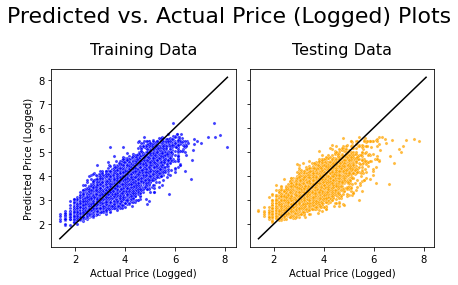

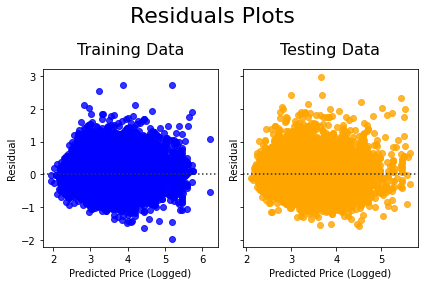

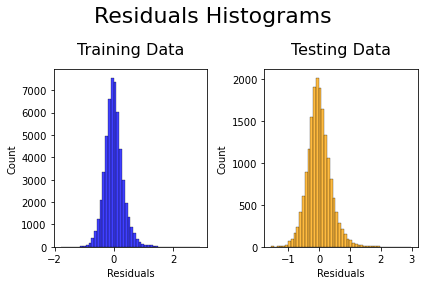

In [79]:
residual_visualizations(pipe_et_gs, X_k_train, y_train, X_k_test, y_test,'Price (Logged)', 50)

**Interpretaton**

#### *Predicted vs. Actual Plots*
- The first plots suggest that our model does not have equality of variance (homoscedasticity of errors).
- They also show a consistent trend.
    * The model is underpredicting for higher priced wines. 
        - This probably reflects the link between price and review score that we saw earlier. 
        - The highest scoring wines went up sharply in price and our model is having trouble accounting for that effect.
    * Our model is overpredicting for lower priced wines.
        - This may be caused by the model skewing to try to predict the higher priced wines.
    
#### *Residuals Plots*

- The second set of plots confirms that our homoscedasticity is not ideal and bolsters the argument that our high priced wines are causing problems for our model. 
    * By far the largest residuals come from wines these wines.
    * Again, we see high consistency between the training data and testing data visualizations, suggesting that we our model has relatively low variance.

#### *Histograms*

- Finally, our residual histograms tell us that our variance is normally distributed. 
    * If anything, due to the higher priced wines, there is a slight right skew due to their large residuals.


#### *Future Studies Implications*
- To improve our models in the future, we should try to do the following: 
    * Adjust our independent variables to create a better model.
        - We may be missing some feature.
        - We may need to transform some independent variable(s).
    * Deal with the outliers.
        - We could eliminate them from this model.
        - If there are enough of them, we could create an additional model for just those wines.

### Coefficient Analysis/Interpretation

While our linear regression model was not our best, it was not bad and it was our most interpretable model. Here again is our model summary.

In [80]:
# Calling the results
KP_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     202.2
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:03:53   Log-Likelihood:                -30807.
No. Observations:               53799   AIC:                         6.235e+04
Df Residuals:                   53429   BIC:                         6.564e+04
Df Model:                         369                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -5.2239      0.101    -51.769      0.000      -5.422      -5.026
points                                             0.0943      0.001    118.316      0.000       0.093       0.096
high_q_term                                        0.0675      0.005     12.820      0.000       0.057       0.078
vintage                                            0.0074      0.001     12.459      0.000       0.006       0.009
country_Argentina                                  0.0961      0.064      1.512      0.131      -0.028       0.221
country_Australia                                  0.1582      0.062      2.563      0.010       0.037       0.279
country_Austria                                    0.2140      0.077      2.768      0.006       0.062       0.366
country_Brazil                                     0.3291      0.132      2.492      0.013       0.070       0.588
country_Bulgaria                                  -0.3699      0.128     -2.886      0.004      -0.621      -0.119
country_Canada                                     0.5051      0.109      4.623      0.000       0.291       0.719
country_Chile                                      0.0623      0.062      1.000      0.317      -0.060       0.184
country_Croatia                                    0.1251      0.148      0.847      0.397      -0.164       0.415
country_France                                     0.2481      0.057      4.374      0.000       0.137       0.359
country_Georgia                                   -0.5013      0.227     -2.210      0.027      -0.946      -0.057
country_Germany                                    0.1135      0.076      1.496      0.135      -0.035       0.262
country_Greece                                     0.1326      0.075      1.774      0.076      -0.014       0.279
country_Hungary                                    0.4832      0.098      4.928      0.000       0.291       0.675
country_Israel                                     0.1378      0.077      1.785      0.074      -0.013       0.289
country_Italy                                      0.1693      0.057      2.968      0.003       0.058       0.281
country_Mexico                                     0.4165      0.092      4.507      0.000       0.235       0.598
country_Moldova                                   -0.2417      0.107     -2.256      0.024      -0.452      -0.032
country_New Zealand                                0.0986      0.084      1.172      0.241      -0.066       0.263
country_Portugal                                  -0.2081      0.076     -2.756      0.006      -0.356      -0.060
country_Romania                                   -0.5848      0.093     -6.273      0.000   

**Interpretation**

- While R-squared is not our metric for this study, the 0.582 score suggests that all of our model is far from perfect.
- That said, it is still valuable to look at the significant features and understand what they mean.

In [81]:
# Code found at:
# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe/52976810
#  Creating a DataFrame from the lower portion of the OLS summary

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [82]:
# calling code to create dataframe
df_ols = results_summary_to_dataframe(results)

Our next step is to create a new column to examine our coefficients. 
- Since they are based on a logged target, we are exponentiating, subtracting one and multiplying by 100. 
- For each, the result is the percentage change in price for a unit change in the feature.
    - Note that for many of our features (including the countries, the regions and the varieties), this just means that if X is true (i.e. the wine is from France), the price increases (or decreases) by this percent.

In [83]:
df_ols['pct_change_in_y'] = (np.exp(df_ols['coeff']) - 1) *100

In [84]:
# Removing quartile ranges from dataframe and moving pct_change next to coeff
df_ols = df_ols.loc[:,['coeff','pct_change_in_y', 'pvals']]
df_ols.head()

,coeff,pct_change_in_y,pvals
const,-5.393250,-99.545283,0.000000e+00
points,0.095965,10.072006,0.000000e+00
high_q_term,0.067302,6.961807,2.664523e-37
vintage,0.007974,0.800583,2.260091e-43
country_Argentina,0.093911,9.846151,1.395584e-01


In [85]:
# Creating masks to (1) limit lists to only significant features (2) separate into groups 
# positive change vs negative change
significant = df_ols['pvals'] <=.05
positive_change = df_ols['pct_change_in_y'] > 0
negative_change = df_ols['pct_change_in_y'] < 0

# Creating a dataframe of signficant positive features and then saving as sorted highest to lowest change
df_ols_pos = df_ols.loc[significant & positive_change]
df_ols_pos = df_ols_pos.sort_values('pct_change_in_y', ascending=False)
# Creating similar dataframe for negative features and dropping the row for our constant
df_ols_neg = df_ols.loc[significant & negative_change]
df_ols_neg = df_ols_neg.sort_values('pct_change_in_y', ascending=True)
df_ols_neg.drop('const', inplace=True)

In [86]:
# confirm positive
df_ols_pos.head()

,coeff,pct_change_in_y,pvals
region_Chambolle-Musigny,0.823103,127.755556,3.445189e-27
region_Vosne-Romanée,0.790914,120.541170,1.378223e-26
region_Amarone della Valpolicella Classico,0.749244,111.539948,1.178897e-91
region_Nuits-St.-Georges,0.727978,107.088999,1.821440e-42
variety_Maturana,0.722531,105.964028,8.270056e-05


In [87]:
# confirm negative
df_ols_neg.head()

,coeff,pct_change_in_y,pvals
region_Vin de Pays d'Oc,-0.684333,-49.557356,6.668393e-21
region_Bordeaux,-0.608079,-45.560408,2.063172e-110
country_Romania,-0.589231,-44.524609,2.644836e-10
region_South Eastern Australia,-0.575096,-43.734907,7.013434e-22
region_California,-0.565907,-43.215528,1.675706e-196


Below, we are plotting the largest 15 variables by percent change for each list. 

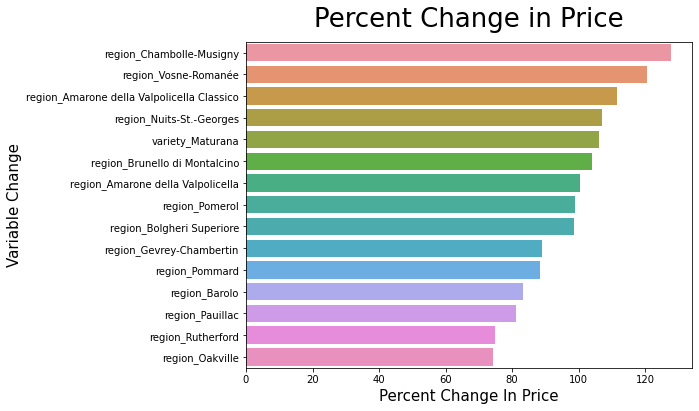

In [88]:
df_ols_pos = df_ols_pos.head(15)

plt.figure(figsize=(8,6))
plt.title('Percent Change in Price',fontsize=26, pad = 15)

# plotting prices x score
ax1 = sns.barplot(x= 'pct_change_in_y',y=df_ols_pos.index,data=df_ols_pos, orient='h')
# ax2 = sns.set(rc={"lines.linewidth": 3})
# ax2 = sns.lineplot(x= [.5,.5], y=[0,1],color='orange');
ax1.set_xlabel('Percent Change In Price', fontsize=15)
ax1.set_ylabel('Variable Change', fontsize=15);

**Interpretation**

- It is interesting to see that 14 of the top 15 positive movers are regions and most of those are european.
- The only non-region is the Maturana varietal, a near-extinct grape from the Rioja region of Spain.
- A few important side notes on the positive side that didn't make our top 15:
    * Our designation feature for reserve wines tells us to expect a 7.2% increase in price for such a wine (assuming all other factors are constant) though we learned in our EDA that the average scores do not suggest we are getting better wine.
    * The review score feature predicts a 10% increase for each point increase in the score (assuming all other factors are constant).
    * Finally, our vintage feature suggests that wine value increases by 0.8% for each year that it ages (assuming all other factors are constant)

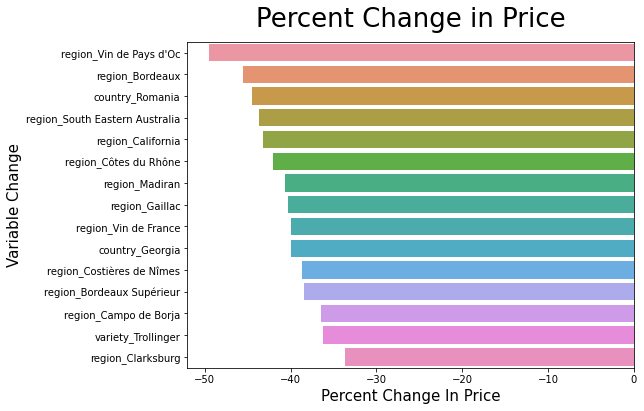

In [89]:
df_ols_neg = df_ols_neg.head(15)

plt.figure(figsize=(8,6))
plt.title('Percent Change in Price',fontsize=26, pad = 15)

# plotting prices x score
ax1 = sns.barplot(x= 'pct_change_in_y',y=df_ols_neg.index,data=df_ols_neg, orient='h')
# ax2 = sns.set(rc={"lines.linewidth": 3})
# ax2 = sns.lineplot(x= [.5,.5], y=[0,1],color='orange');
ax1.set_xlabel('Percent Change In Price', fontsize=15)
ax1.set_ylabel('Variable Change', fontsize=15);

**Interpretation**

- 11 of the 15 negative movers are regions and again we see quite a few european regions.
    - Others of interest are Australia and Cotes du Rhone (our favorite).
- The non-region items here can best be described as obscure when it comes to wine.
    - We rarely see wines from Romania or Georgia (the country).
    - Agiorgitiko and Dornfelder are varietals we have sampled.

[Table of Contents](#Table-of-Contents)
## Conclusions & Next Steps

Our exploratory data and model coefficient analysis have helped us along to path to understanding how the price of wine and how we can make our drinking budgets go further.

**EDA Learnings**
- Using a cost-per-point metric, we were able to find countries, regions and wine varietals that offer a lower cost for the same review score. 
    * For those of us who like wines that fall on the right side of this analysis, we can save money by buying wines that we already like or step in quality not pay too much to do so.
    * The next step here for our team is to try different varietals with the same score. Then each of us can judge how consistently we can trust these reviews.
- Our exploration of the words in the wine reviews gave us a feel for some of the factors that people look for in a premium red wine:
    * Oak barrels
    * Cabernet over Pinot Noir
- EDA on our clustered data seemed to suggest that we have made some good choices in choosing our features as the KPrototypes clustering gave us some more or less distinct groups of wines.
    * With additional data points and a balance of wines, it will be interesting to see how these might change in future studies.

**Modeling Learnings**
- Our predictive model is off to a nice start but it certainly is not ready for prime time. 
    * While it looks pretty good  up to about \\$150, things go a little off of the rails after that.
- Our coefficient analysis can point us in directions to save money on a quality wine or avoid some of the factors that can jack up the price. 
    * From now on, we will be looking a little closer before buying a bottle of the newest reserve wine and try to locate a wine from the same region with comparable reviews.

**Future Research**
- In gathering our data, we did find some great data resources that we didn't have the budget to pay for. 
- With this data, we could both expand and narrow our study. 
    * Expanding to include more wines and more reviews from multiple review sources, perhaps creating an average review score.
    * We can also narrow our scope on pricing side, averaging what we would pay at a set of retailers that we can actually access,
- If forced, we're even willing to include white wine.


## References

- [Kaggle Study: Source for Actual Data & Data Scraper](https://www.kaggle.com/zynicide/wine-reviews)
- [Wine Enthusiast Website: Source of Original Data & Missing Data](https://www.winemag.com/)
- [Wine Searcher Website: Used for Variety/Region Study](https://www.wine-searcher.com/grape-varieties)
- [The Wine Cellar Insider Website: Used for Variety/Region Study](https://www.thewinecellarinsider.com/wine-topics/wine-educational-questions/abc-of-wine-glossary-of-wine-terms/)
- [Example of Wikipedia Page Used for Variety/Region Study](https://en.wikipedia.org/wiki/Pinot_noir#Synonyms)
- [University of Virginia Webpage Used to Understand Interpretation of Linear Regressions with Log-Transformed Data](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/)